# Time-Series Trend Analysis (Tuition Gap Stationarity Diagnostics)

This analysis examines whether the University of Virginia’s tuition gap (the difference between out-of-state and in-state tuition) behaves as a stationary time series, which is essential for accurate forecasting using ARIMA and Holt’s models.

## Pipeline Steps
1. Time-Index Conversion
- The dataset (Combined_UVA_Tuition_Cleaned.csv) was converted into a time-indexed format using Year_Start as the index. This ensures each year from 1970 to 2025 is treated as a sequential time point, allowing time-based operations such as rolling calculations, differencing, and autocorrelation analysis.

2. Rolling-Window Statistics (5-Year Smoothing)
- Rolling statistics were used to visualize long-term patterns in the tuition gap.
- The rolling mean highlights the underlying trend by smoothing out short-term fluctuations.
- The rolling standard deviation tracks how much the series varies over time.
- If either the mean or standard deviation changes systematically, the data are non-stationary.
The resulting plot shows:
- Purple line: Original tuition gap series
- Orange line: 5-year rolling mean (trend)
- Green line: 5-year rolling standard deviation (volatility)

3. Augmented Dickey–Fuller (ADF) Test
- The ADF test formally evaluates whether the time series is stationary.
- The null hypothesis assumes the series is non-stationary.
- The alternative hypothesis assumes it is stationary.
- A p-value less than 0.05 indicates that the null hypothesis can be rejected, confirming stationarity.
- In this analysis, the p-value was approximately 1.0, indicating a strong upward trend and confirming that the tuition gap is non-stationary.

4. Autocorrelation and Partial Autocorrelation (ACF/PACF)
- Autocorrelation and partial autocorrelation plots were generated to understand how each year’s tuition gap correlates with previous years.
- The ACF plot shows how current values depend on past values (lagged correlations).
- The PACF plot identifies which specific lags have the strongest direct influence.
- These plots help guide the selection of ARIMA model parameters (p and q) for forecasting.

5. First-Differencing (Trend Removal)
- Because the ADF test indicated non-stationarity, the series was differenced once to remove the linear trend.
- Differencing converts the data from “tuition gap values” to “year-to-year changes,” creating a more stable series suitable for modeling.
- The differenced plot shows the transformed data fluctuating around a constant mean, indicating that the series is now approximately stationary.

In [24]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, os
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [25]:
DATA_PATH = "../DATA/Combined_UVA_Tuition_Cleaned.csv"
OUT_DIR = "../OUTPUT/02_trend_analysis/"
os.makedirs(OUT_DIR, exist_ok=True)

df = pd.read_csv(DATA_PATH).sort_values("Year_Start")
ts = pd.Series(df["Tuition_Gap"].values,
               index=pd.to_datetime(df["Year_Start"].astype(str), format="%Y"))
ts.name = "Tuition_Gap"

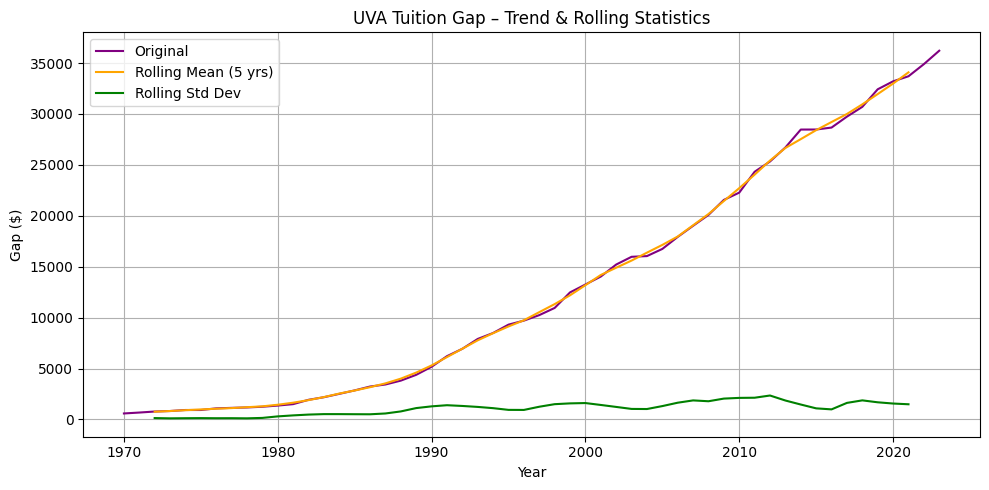

In [26]:
roll_mean = ts.rolling(window=5, center=True).mean()
roll_std  = ts.rolling(window=5, center=True).std()

plt.figure(figsize=(10,5))
plt.plot(ts, label="Original", color="purple")
plt.plot(roll_mean, label="Rolling Mean (5 yrs)", color="orange")
plt.plot(roll_std, label="Rolling Std Dev", color="green")
plt.title("UVA Tuition Gap – Trend & Rolling Statistics")
plt.xlabel("Year"); plt.ylabel("Gap ($)")
plt.legend(); plt.grid(True); plt.tight_layout()
plt.savefig(f"{OUT_DIR}/rolling_stats_plot.png", dpi=200)


In [27]:
# 3. ADF test (stationarity)
adf_result = adfuller(ts)
adf_summary = pd.DataFrame({
    "ADF Statistic": [adf_result[0]],
    "p-value": [adf_result[1]],
    "Used Lags": [adf_result[2]],
    "N Obs": [adf_result[3]],
})
for key, val in adf_result[4].items():
    adf_summary[f"Critical Value ({key})"] = [val]
adf_summary.to_csv(f"{OUT_DIR}/ts_adf_results.csv", index=False)
print(adf_summary)

   ADF Statistic  p-value  Used Lags  N Obs  Critical Value (1%)  \
0       5.450469      1.0          0     53            -3.560242   

   Critical Value (5%)  Critical Value (10%)  
0             -2.91785             -2.596796  


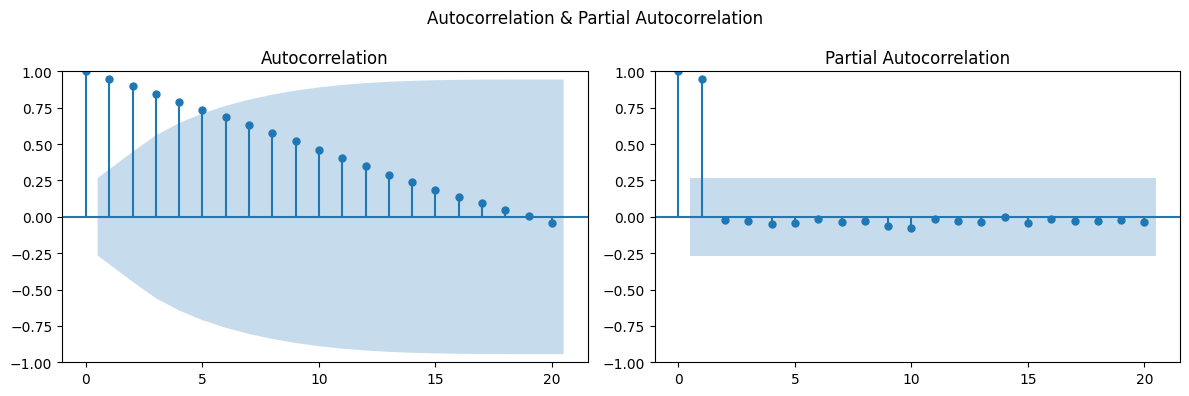

In [28]:

# 4. ACF / PACF plots
fig, ax = plt.subplots(1, 2, figsize=(12,4))
plot_acf(ts, ax=ax[0], lags=20)
plot_pacf(ts, ax=ax[1], lags=20, method="ywm")
fig.suptitle("Autocorrelation & Partial Autocorrelation")
plt.tight_layout(); plt.savefig(f"{OUT_DIR}/acf_pacf_plots.png", dpi=200)


Data not stationary (p > 0.05). First difference saved.


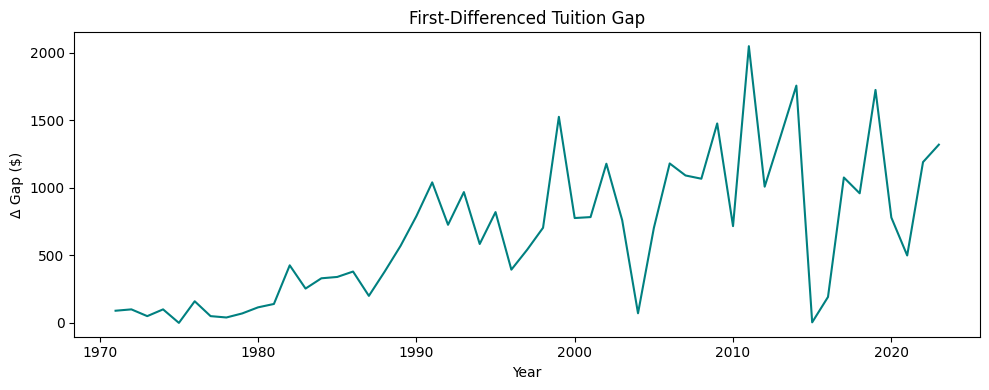

In [29]:
# 5. Differencing if not stationary
if adf_result[1] > 0.05:
    ts_diff = ts.diff().dropna()
    plt.figure(figsize=(10,4))
    plt.plot(ts_diff, color="teal")
    plt.title("First-Differenced Tuition Gap")
    plt.xlabel("Year"); plt.ylabel("Δ Gap ($)")
    plt.tight_layout(); plt.savefig(f"{OUT_DIR}/first_difference_plot.png", dpi=200)
    print("Data not stationary (p > 0.05). First difference saved.")
else:
    print("Series is stationary (p < 0.05). No differencing needed.")
